In [1]:
import pandas as pd
import os
import numpy as np
import dask.dataframe as dd 
import warnings 
warnings.filterwarnings("ignore")



In [2]:
# Fichier avec les variables d'intéret :

df_cct = pd.read_parquet("/home/onyxia/work/Projet-Statapp/g/cct_var_new.parquet")

In [4]:
df_cct.head()

User  Card       date           timestamp  Amount           Use Chip  \
0     0     0 2002-09-01 2002-09-01 06:21:00  134.09  Swipe Transaction   
1     0     0 2002-09-01 2002-09-01 06:42:00   38.48  Swipe Transaction   
2     0     0 2002-09-02 2002-09-02 06:22:00  120.34  Swipe Transaction   
3     0     0 2002-09-02 2002-09-02 17:45:00  128.95  Swipe Transaction   
4     0     0 2002-09-03 2002-09-03 06:23:00  104.71  Swipe Transaction   

         Merchant Name  Merchant City Merchant State      Zip  ...  \
0  3527213246127876953       La Verne             CA  91750.0  ...   
1  -727612092139916043  Monterey Park             CA  91754.0  ...   
2  -727612092139916043  Monterey Park             CA  91754.0  ...   
3  3414527459579106770  Monterey Park             CA  91754.0  ...   
4  5817218446178736267       La Verne             CA  91750.0  ...   

   wk_med_amt wk_i_med_amt  nbt_wk_i/amt_wk_i  amt/day_income  \
0     1380.96       90.015           0.177748        0.819868   
1     1380.96       90.015           0.177748        0.235279   
2     1380.96       90.015           0.177748        0.735796   
3     1380.96       90.015           0.177748        0.788441   
4     1380.96       90.015           0.177748        0.640230   

   merchant_user_state_is_diff  rolling_nb_frauds_wk  rolling_nbt_wk  \
0                            0                   0.0             1.0   
1                            0                   0.0             2.0   
2                            0                   0.0             3.0   
3                            0                   0.0             4.0   
4                            0                   0.0             5.0   

   rolling_amt_wk  rolling_amt_med_wk  rolling_nbt_wk/amt_wk  
0          134.09             134.090               0.007458  
1          172.57              86.285               0.011589  
2          292.91             120.340               0.010242  
3          421.86             124.645               0.009482  
4          526.57             120.340               0.009495  

[5 rows x 31 columns]

In [5]:
df_cct.columns

Index(['User', 'Card', 'date', 'timestamp', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'delta_t_s', 'delta_t_s_card', 'day_amt',
       'day_nbt', 'day_med_nbt', 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i', 'amt/day_income',
       'merchant_user_state_is_diff', 'rolling_nb_frauds_wk', 'rolling_nbt_wk',
       'rolling_amt_wk', 'rolling_amt_med_wk', 'rolling_nbt_wk/amt_wk'],
      dtype='object')

In [6]:
#df_cct.columns

# Retirer les variables inutiles : trop corrélées aux autres : 'day_amt', 'day_nbt', 'day_med_nbt', 
# 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt', 'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i'.? 
# merchant_user_state_is_diff inutile : toujours identique.
df_cct =  df_cct.drop(["merchant_user_state_is_diff", 'day_amt',
       'day_nbt', 'day_med_nbt', 'wk_i_nbt', 'wk_med_nbt', 'wk_i_amt',
       'wk_med_amt', 'wk_i_med_amt', 'nbt_wk_i/amt_wk_i'], axis = 1)

In [7]:
df_cct =  df_cct.drop(["date"], axis = 1) # toute l'information est dans timestamp.

df_cct =  df_cct.drop(["Zip"], axis = 1) # inutile : information avec Merchant City (suffisamment précis).

# Drop "User" et "Merchant Name" : Discriment trop les transactions en fonctions des Users : on veut 
# une analyse sur les transactions.

df_cct =  df_cct.drop(["User", "Merchant Name"], axis = 1)

In [8]:
# Gérer les variables catégorielles pour DBSCAN. 
# Eviter le problème de hiérarchie entre les modalités : 
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html?fbclid=IwAR2eCoPI9skUHDegZeP31K--Psh2thHY_5anQPtngWD6qU3caG1UxFdwtR4

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Ex : On commence par les colonnes "Errors"     (A faire  "Merchant State", "Merchant City", "Use Chip")

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Errors?"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [10]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [11]:
# Pour "Merchant State" : 


enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant State"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [12]:
# Pour "Merchant City" : 

enc = OneHotEncoder(handle_unknown='ignore',  max_categories=10)

features_array = enc.fit_transform(df_cct[["Merchant City"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)


In [13]:
# Gerer le type : datetime64[ns]

df_cct["timestamp"] = df_cct["timestamp"].values.astype("float64")

df_cct =  df_cct.drop(["Merchant State", "Merchant City", "Errors?", "Use Chip"], axis = 1)

# On retire également la variable "Card" : pas d'intérêt pour le clustering
# On souhaite étudier les types de transaction de manière générale. 
df_cct =  df_cct.drop(["Card" ], axis = 1)


In [14]:
# Centrer réduire les variables : 

for i in range(len(df_cct.columns)):
    mean = np.mean(df_cct[df_cct.columns[i]])
    ec = np.std(df_cct[df_cct.columns[i]])
    df_cct[df_cct.columns[i]] = (df_cct[df_cct.columns[i]]-mean)/ec


df_cct.head()

timestamp    Amount       MCC  Is Fraud?  delta_t_s  delta_t_s_card  \
0  -1.920203  1.102821 -0.297017  -0.034953  -0.000006       -0.092117   
1  -1.920196 -0.062837 -0.170782  -0.034953   0.000321       -0.090357   
2  -1.919666  0.935184 -0.170782  -0.034953   0.022107        0.026931   
3  -1.919411  1.040155  0.102158  -0.034953   0.010630       -0.034856   
4  -1.919129  0.744626  0.398979  -0.034953   0.011798       -0.028569   

   amt/day_income  rolling_nb_frauds_wk  rolling_nbt_wk  rolling_amt_wk  ...  \
0       -0.013158             -0.069941       -1.783847       -1.237541  ...   
1       -0.015758             -0.069941       -1.710999       -1.187297  ...   
2       -0.013532             -0.069941       -1.638150       -1.030167  ...   
3       -0.013297             -0.069941       -1.565301       -0.861794  ...   
4       -0.013957             -0.069941       -1.492453       -0.725072  ...   

   Merchant City_Brooklyn  Merchant City_Chicago  Merchant City_Dallas  \
0               -0.080089              -0.074933             -0.074561   
1               -0.080089              -0.074933             -0.074561   
2               -0.080089              -0.074933             -0.074561   
3               -0.080089              -0.074933             -0.074561   
4               -0.080089              -0.074933             -0.074561   

   Merchant City_Houston  Merchant City_Indianapolis  \
0              -0.100954                   -0.070584   
1              -0.100954                   -0.070584   
2              -0.100954                   -0.070584   
3              -0.100954                   -0.070584   
4              -0.100954                   -0.070584   

   Merchant City_Los Angeles  Merchant City_Miami  Merchant City_ONLINE  \
0                  -0.086351            -0.085906             -0.354372   
1                  -0.086351            -0.085906             -0.354372   
2                  -0.086351            -0.085906             -0.354372   
3                  -0.086351            -0.085906             -0.354372   
4                  -0.086351            -0.085906             -0.354372   

   Merchant City_Orlando  Merchant City_infrequent_sklearn  
0              -0.070548                          0.442558  
1              -0.070548                          0.442558  
2              -0.070548                          0.442558  
3              -0.070548                          0.442558  
4              -0.070548                          0.442558  

[5 rows x 45 columns]

In [15]:
#Est ce que il y a des nan ? 
print(df_cct.isna().all())

timestamp                               False
Amount                                  False
MCC                                     False
Is Fraud?                               False
delta_t_s                               False
delta_t_s_card                          False
amt/day_income                          False
rolling_nb_frauds_wk                    False
rolling_nbt_wk                          False
rolling_amt_wk                          False
rolling_amt_med_wk                      False
rolling_nbt_wk/amt_wk                    True
Errors?_Bad CVV                         False
Errors?_Bad Card Number                 False
Errors?_Bad Expiration                  False
Errors?_Bad PIN                         False
Errors?_Bad PIN,Insufficient Balance    False
Errors?_Bad Zipcode                     False
Errors?_Insufficient Balance            False
Errors?_Technical Glitch                False
Errors?_None                            False
Errors?_infrequent_sklearn        

In [16]:
# On supprime les colonnes avec que des NaN : rolling_nbt_wk/amt_wk : 
df_cct =  df_cct.drop(["rolling_nbt_wk/amt_wk"], axis = 1)

In [17]:
import pandas.util.testing as tm
import seaborn as sns
from sklearn import cluster 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from collections import Counter

In [18]:
# Problème de puissance de calcul on fait DBSCAN seulement sur les 100 000 premières transactions... :((
df_cct1 = df_cct.copy()
df_cct = df_cct.head(150000)

In [19]:
# Implémentation de DBSCAN : 

X = df_cct.values
X.astype(np.float64)

array([[-1.92020339,  1.10282079, -0.29701658, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.92019556, -0.06283656, -0.17078201, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       [-1.91966596,  0.93518363, -0.17078201, ..., -0.35437235,
        -0.0705477 ,  0.44255806],
       ...,
       [-1.41371273, -0.38908895, -0.88383672, ...,  2.82189062,
        -0.0705477 , -2.25959052],
       [-1.4137049 , -0.27826555,  0.28866632, ...,  2.82189062,
        -0.0705477 , -2.25959052],
       [-1.41363702,  0.09199921,  0.43309686, ..., -0.35437235,
        -0.0705477 ,  0.44255806]])

In [20]:
# Maintenant que nous avons notre jeu de données nous allons chercher à déterminer le ε optimal
# pour obtenir un meilleur partitionnement de notre jeu de données. 
# On veut que 90 à 95 % des observations aient au moins 4 voisins dans leur epsilon-voisinage. 
# On veut éviter un trop grand nombre d'outliers. 
# On part sur un min_sample à 5. 

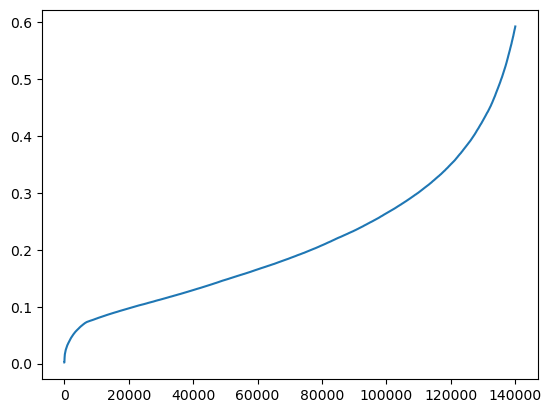

In [21]:
#Scikit-Learn met à disposition une classe NearestNeighbors qui permet de déterminer 
# les voisins les plus proches de chaque observation ainsi que les distances. 

%matplotlib inline
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:140000,1]
plt.plot(distances);

# Conclusion : prendre eps = 0.6, de tel sorte que au moins 95 % des observations appartiennent à un 
# groupe pour un min_sample = 5. 

In [22]:
# Choix de eps et min_samples :

# Choix de eps : 

# Aurre possibilité pour choisir eps : 

#Eps=np.linspace(1,2.5,num=10)
#N=[]
#L=[]
#for eps in Eps:
  #clustering =  cluster.DBSCAN(eps=eps, min_samples=5)
  #clustering.fit(X)
  #labels = clustering.labels_
  #L.append(labels)
  #n=np.unique(labels)
  #N+=[len(n)]

#sns.lineplot(x=Eps,y=N)


# Nbr d'outliers : 

#for s in L:
    #d = Counter(s)
    #for i in d:
        #print(i, d[i])

<AxesSubplot: >

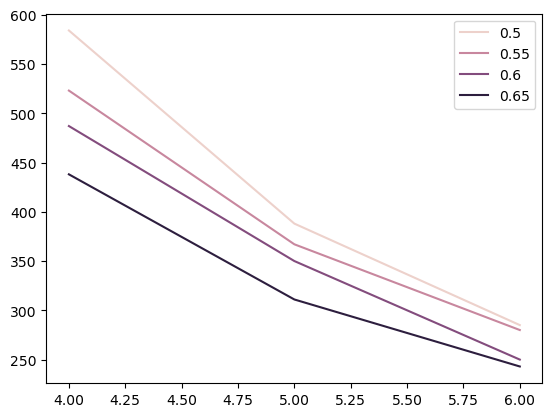

In [23]:
 # Choix de min_samples : On test des eps autour de 0.6 avec des min_sample = 4 ou 5 ou 6. 

Eps = [0.5,0.55,0.6,0.65]
Sample = [4,5,6]
N=[]

x = []
hue = []

for sample in Sample:
  for eps in Eps:
    clustering=cluster.DBSCAN(eps, min_samples=sample)
    clustering.fit(X)
    labels=clustering.labels_
    n=np.unique(labels)
    N+=[len(n)]

    x.append(eps) 
    hue.append(sample)

sns.lineplot(x= hue,y=N, hue = x)

# On affiche le nombre de groupe crée : 
# Essayons avec 6 voisins pour réduire le nombre de groupes et un eps à 0.65 : 

In [24]:
# Choix intéressant pour eps et min_samples :  0.65 et 6

clustering=cluster.DBSCAN(eps=0.65, min_samples=6)
clustering.fit(X)
np.unique(clustering.labels_)

# Nombre de groupes : 

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

In [25]:
labels = clustering.labels_
d = Counter(labels)
d[-1]


# Nombre d'outliers pour ce choix de eps et min_sample : 
# Environ 10 %  

13746

In [26]:
# ACP : réduction de dimension => représenter la méthode DBSCAN (nuage de points)
# On utilise les 2 dimensions les plus représentatives du sample (dim 1 et dim 2, les valeurs 
# avec les valeurs propres les plus grandes.) 

pca = PCA()
pca.fit(df_cct)
df_cct.columns = df_cct.columns.astype("str")
df_cct_pca = pca.transform(df_cct)
df_cct_pca_df = pd.DataFrame({
    "Dim1" : df_cct_pca[:,0], 
    "Dim2" : df_cct_pca[:,1]})
df_cct_pca_df["labels"] = clustering.labels_

In [27]:
# Faire apparaître les valeurs propres sur l'ACP.  => Interpréter / comprendre les axes + représentatifs ? 


eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig


Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1        7.763116e+00                  21.0                   21.0
1       Dim2        2.798574e+00                   8.0                   29.0
2       Dim3        2.453246e+00                   7.0                   35.0
3       Dim4        2.286618e+00                   6.0                   41.0
4       Dim5        1.926634e+00                   5.0                   47.0
5       Dim6        1.880855e+00                   5.0                   52.0
6       Dim7        1.760038e+00                   5.0                   57.0
7       Dim8        1.719915e+00                   5.0                   61.0
8       Dim9        1.618678e+00                   4.0                   66.0
9      Dim10        1.502695e+00                   4.0                   70.0
10     Dim11        1.387264e+00                   4.0                   73.0
11     Dim12        1.146035e+00                   3.0                   76.0
12     Dim13        9.906041e-01                   3.0                   79.0
13     Dim14        9.161722e-01                   2.0                   82.0
14     Dim15        8.874432e-01                   2.0                   84.0
15     Dim16        8.396966e-01                   2.0                   86.0
16     Dim17        7.505485e-01                   2.0                   88.0
17     Dim18        7.355447e-01                   2.0                   90.0
18     Dim19        6.940507e-01                   2.0                   92.0
19     Dim20        6.276522e-01                   2.0                   94.0
20     Dim21        4.356252e-01                   1.0                   95.0
21     Dim22        3.228097e-01                   1.0                   96.0
22     Dim23        2.123783e-01                   1.0                   97.0
23     Dim24        1.934401e-01                   1.0                   97.0
24     Dim25        1.736933e-01                   0.0                   98.0
25     Dim26        1.554376e-01                   0.0                   98.0
26     Dim27        1.405181e-01                   0.0                   98.0
27     Dim28        1.017410e-01                   0.0                   99.0
28     Dim29        9.166706e-02                   0.0                   99.0
29     Dim30        8.529984e-02                   0.0                   99.0
30     Dim31        7.840828e-02                   0.0                   99.0
31     Dim32        6.664192e-02                   0.0                   99.0
32     Dim33        4.891260e-02                   0.0                  100.0
33     Dim34        4.614776e-02                   0.0                  100.0
34     Dim35        3.846923e-02                   0.0                  100.0
35     Dim36        3.199953e-02                   0.0                  100.0
36     Dim37        1.970379e-02                   0.0                  100.0
37     Dim38        2.494271e-03                   0.0                  100.0
38     Dim39        2.161258e-06                   0.0                  100.0
39     Dim40        1.531005e-30                   0.0                  100.0
40     Dim41        2.883205e-31                   0.0                  100.0
41     Dim42        5.375295e-32                   0.0                  100.0
42     Dim43        5.124688e-32                   0.0                  100.0
43     Dim44        3.321168e-32                   0.0                  100.0

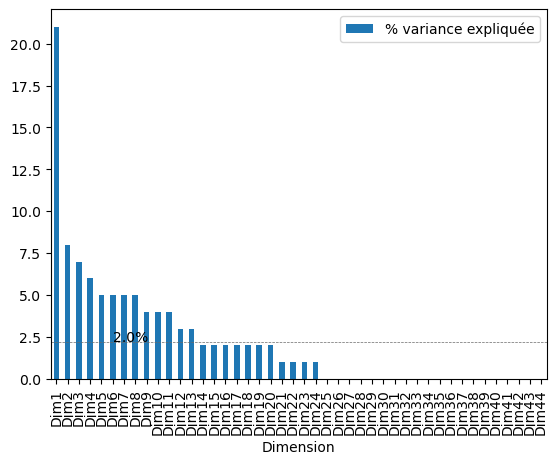

In [28]:
import matplotlib.pyplot as plt

eig.plot.bar(x = "Dimension", y = "% variance expliquée") # permet un diagramme en barres
plt.text(5, 100/(len(pca.explained_variance_)+1), str(np.round(100/(len(pca.explained_variance_)+1)))+"%") # ajout de texte
plt.axhline(y = (100/(len(pca.explained_variance_)+1)), linewidth = .5, color = "dimgray", linestyle = "--") # (100/(len(pca.explained_variance_)+1)) (nb dimensions)
plt.show()


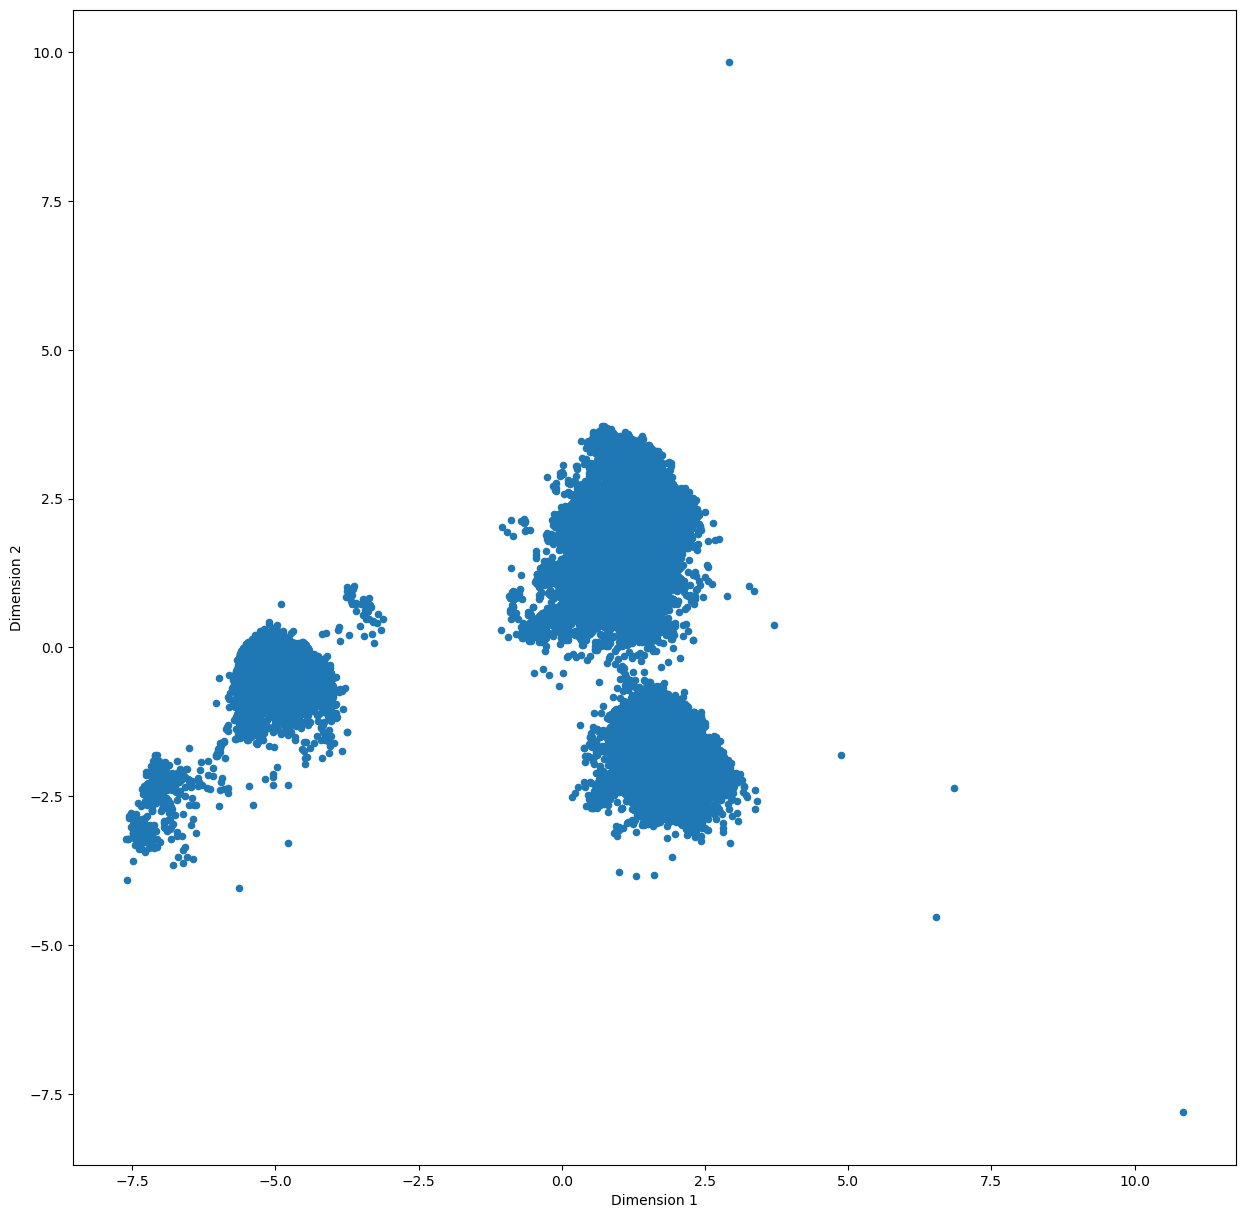

In [29]:
# Représentation de l'ACP :

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
df_cct_pca_df.plot.scatter("Dim1", "Dim2", ax = ax)

# boucle sur chaque pays
# for k in df_cct_pca_df.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    # if (abs(k[1]['Dim1']) > 5) & (abs(k[1]['Dim2']) > 5):
        # ax.annotate(k[1]["Amount"], (k[1]['Dim1'], k[1]['Dim2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

<AxesSubplot: xlabel='Dim1', ylabel='Dim2'>

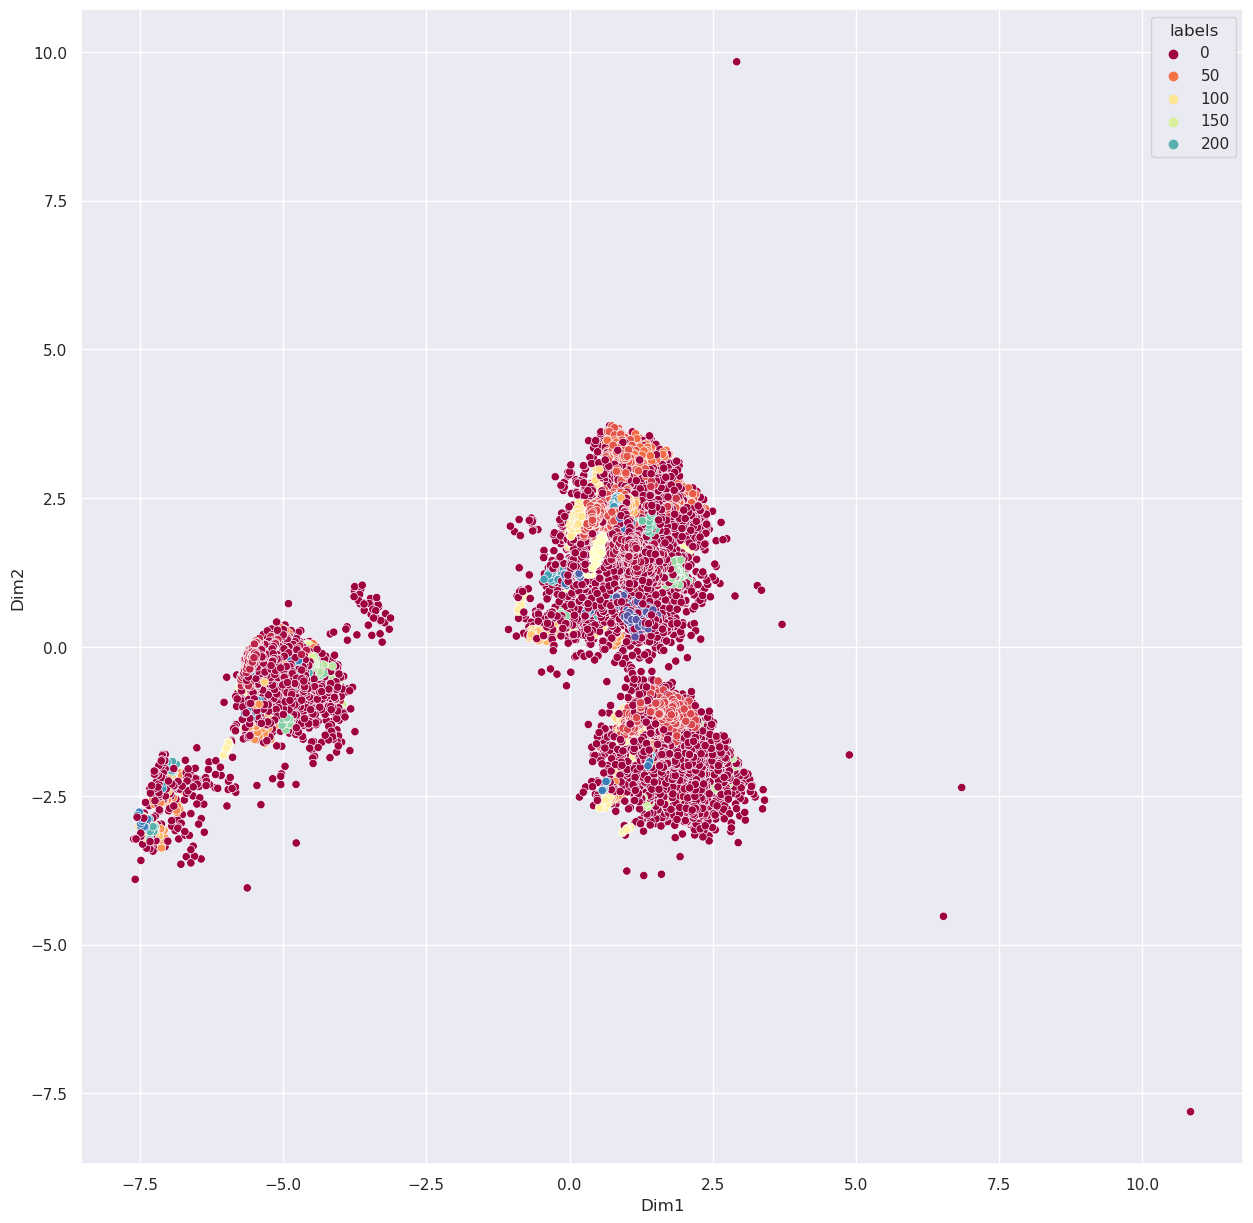

In [30]:
# Représentation de DBSCAN avec l'ACP : 
sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = df_cct_pca_df, x = "Dim1", y = "Dim2", hue = df_cct_pca_df["labels"], palette="Spectral")

In [31]:
#!!!!!!!!!!!!!!!!!!!
# ACP en cascade :........................
#- ACP en cascade : sélectionner 10 familles de variables, faire une ACP sur chaque famille, 
# récupérer les axes, faire une 2e ACP sur toutes les ACP (pour enlever le problème des variables catégorielles)
# Sparse ACP ?
#!!!!!!!!!!!!!!!!!!!

In [33]:
#!pip install umap-learn

In [34]:
# Un simple !pip install umap et import umap ne fonctionne pas... 
import umap.umap_ as umap

In [35]:
# UMAP : autre méthode de réduction de dimension :

reducer = umap.UMAP()
reduced_X = reducer.fit_transform(df_cct.values)

In [36]:
reduced_df = pd.DataFrame(reduced_X, columns = ["A1", "A2"])
reduced_df["Label"] = clustering.labels_

<AxesSubplot: xlabel='A1', ylabel='A2'>

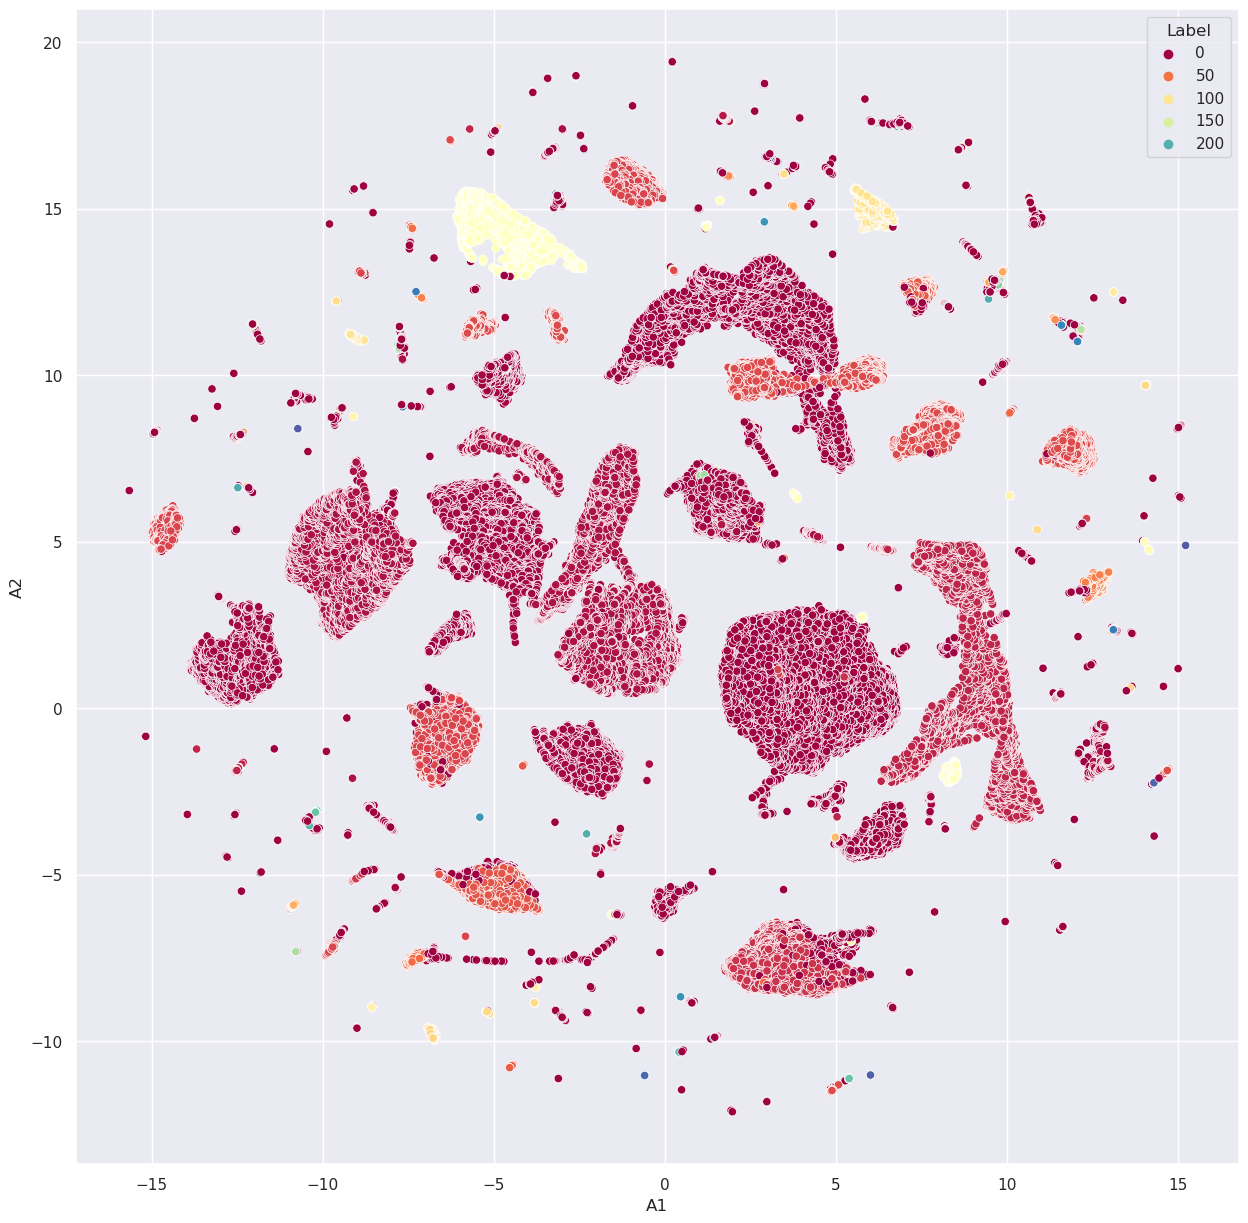

In [37]:
# Représentation de DBSCAN avec UMAP : 

sns.set(rc = {'figure.figsize':(15,15)})
sns.scatterplot(data = reduced_df, x = "A1", y = "A2", hue = "Label", palette="Spectral")

In [38]:
# Interprétation des résultats : On commence par le DBSCAN / umap : 

# 1 Trouver les points correspondant à des frands : 

# Quelle valeur correspond à une transaction en ligne ? 

df_cct["Online Transaction"].unique()

# Valeur :  2.82633622
val = df_cct["Online Transaction"].unique()[1]

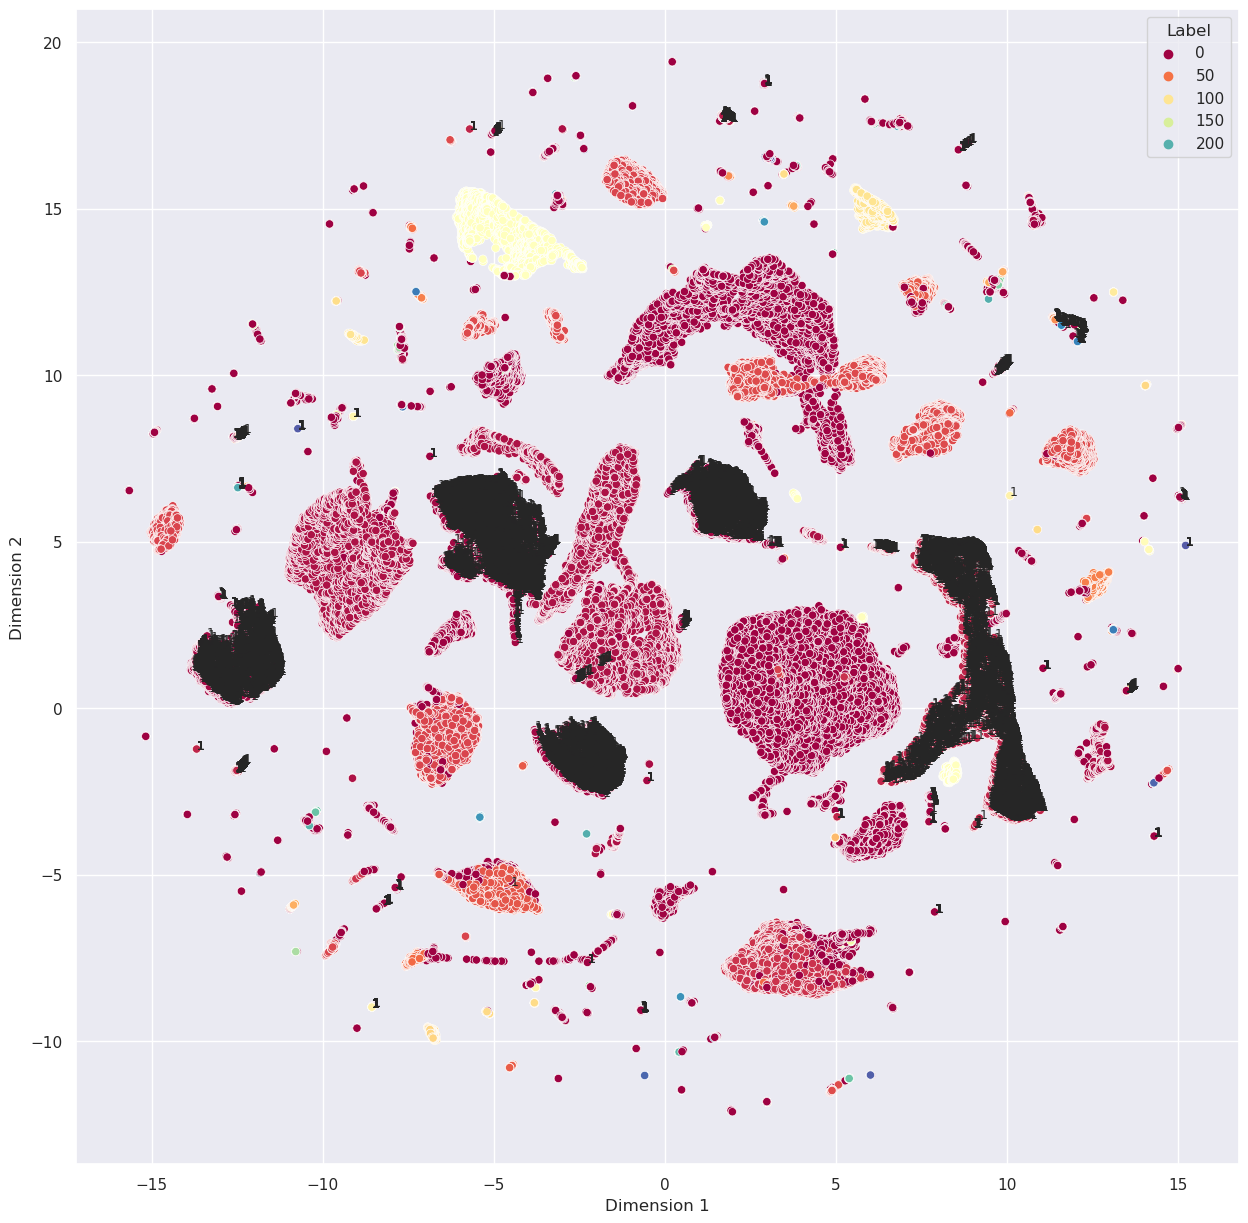

In [39]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Online Transaction"]], axis = 1)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]['Online Transaction'] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


# Intéressant : clairement les transactions en ligne ont été rassemblées dans certains paquets.


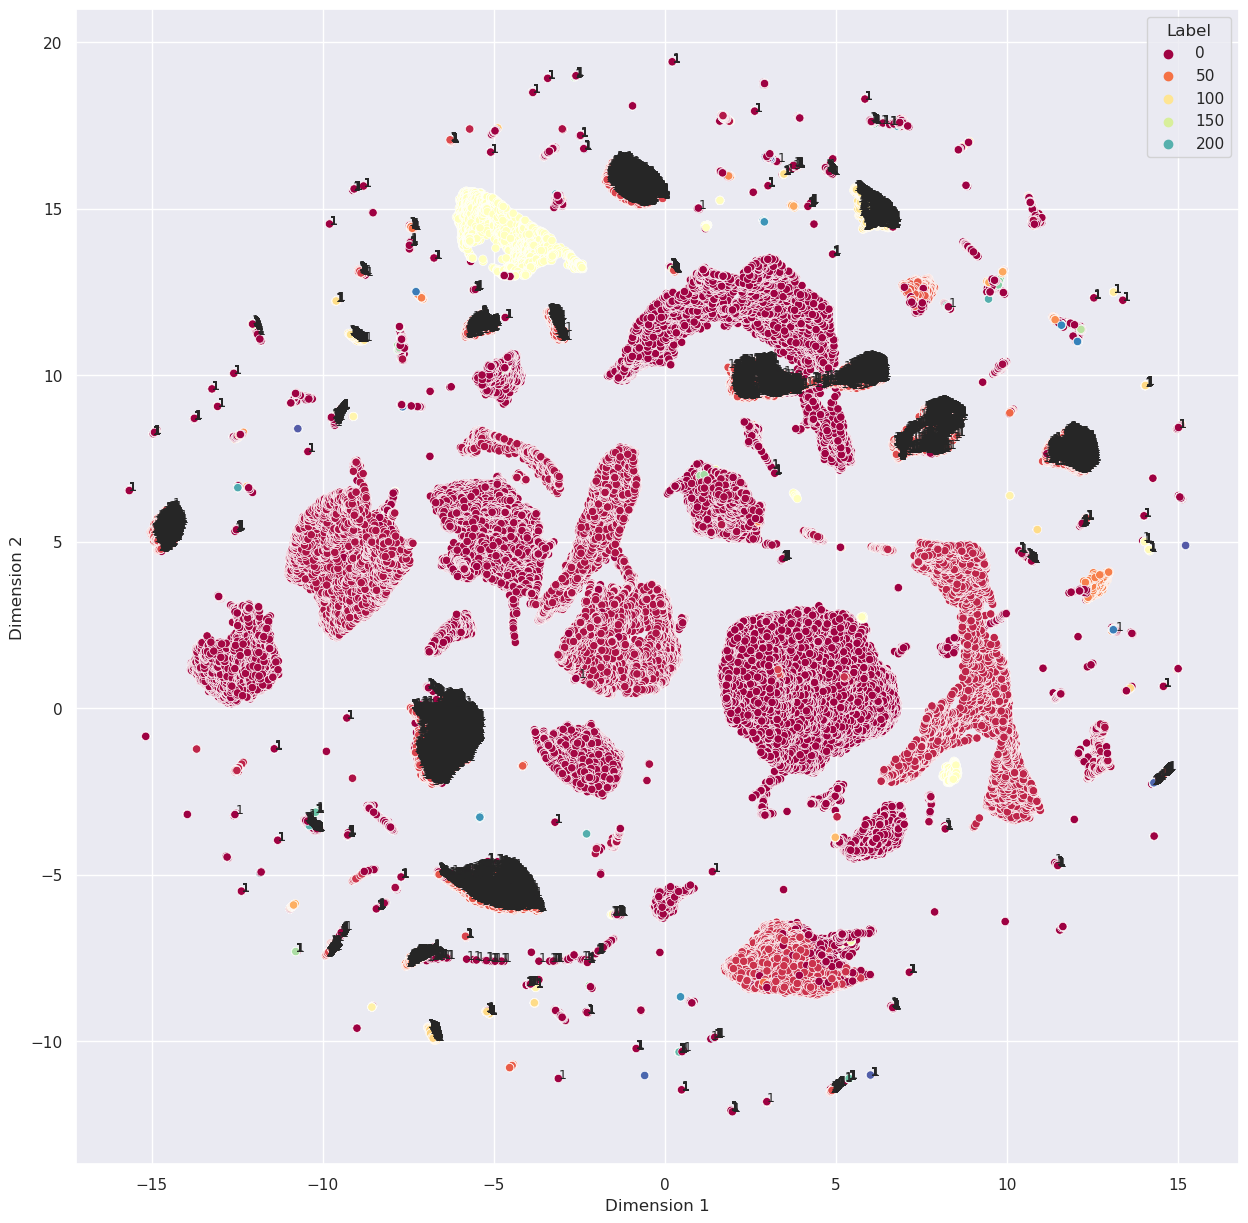

In [40]:
# Essayons pour les autres types de transaction : 

reduced_dfbis = pd.concat([reduced_df, df_cct["Chip Transaction"]], axis = 1)

val = df_cct["Chip Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Chip Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

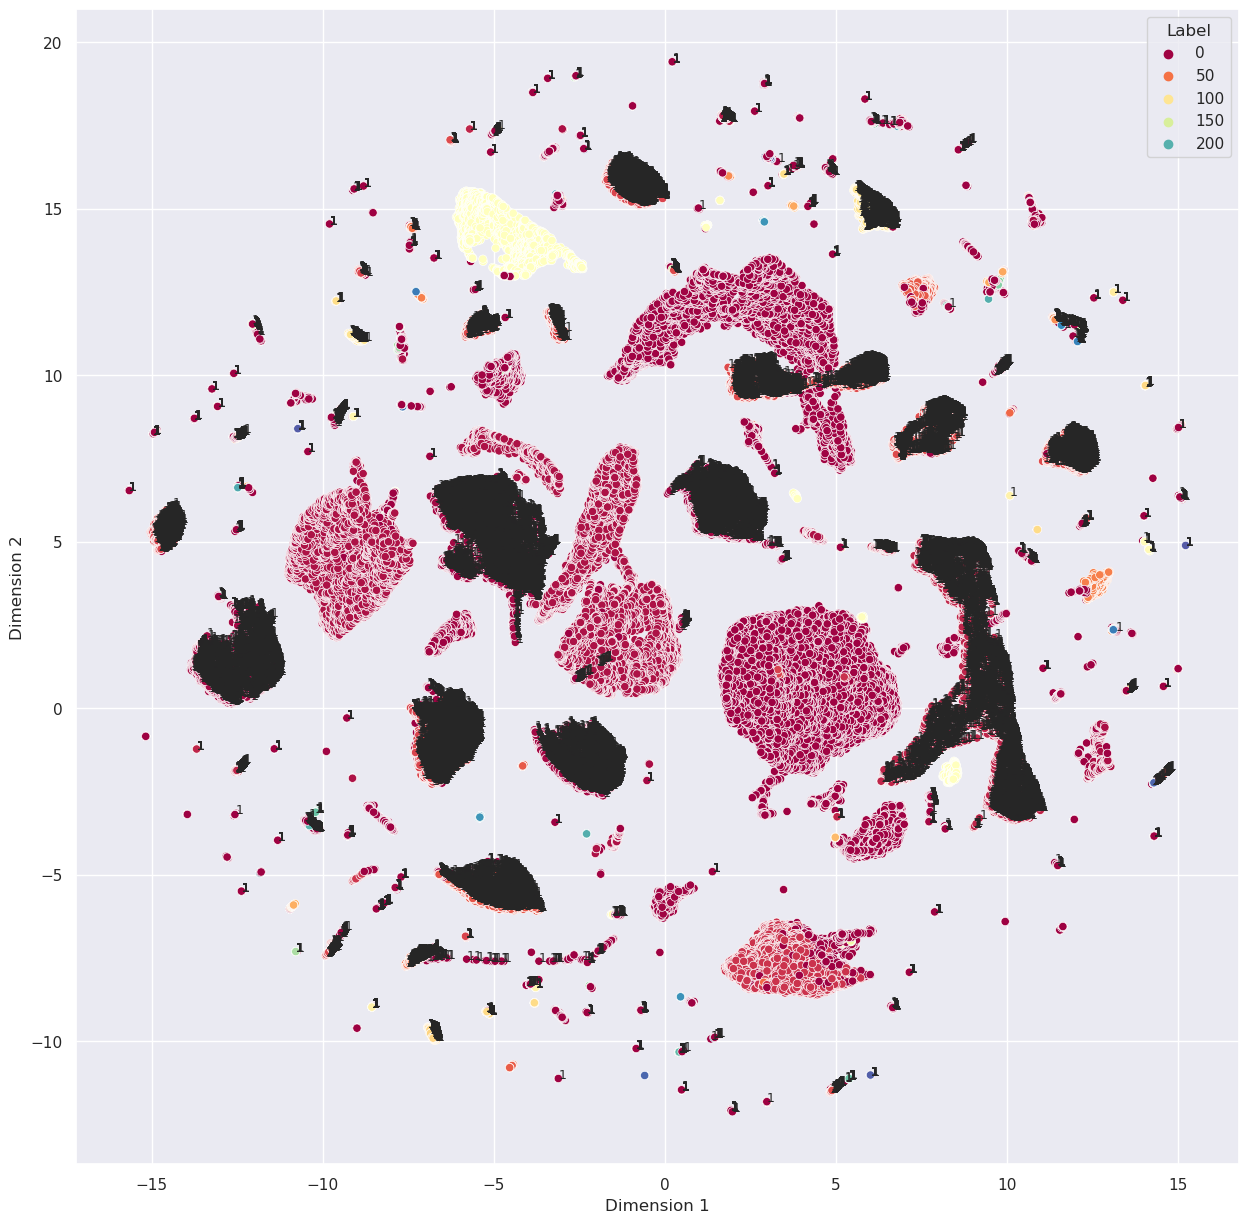

In [41]:
reduced_dfbis = pd.concat([reduced_df, df_cct["Swipe Transaction"]], axis = 1)

val = df_cct["Swipe Transaction"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Swipe Transaction"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

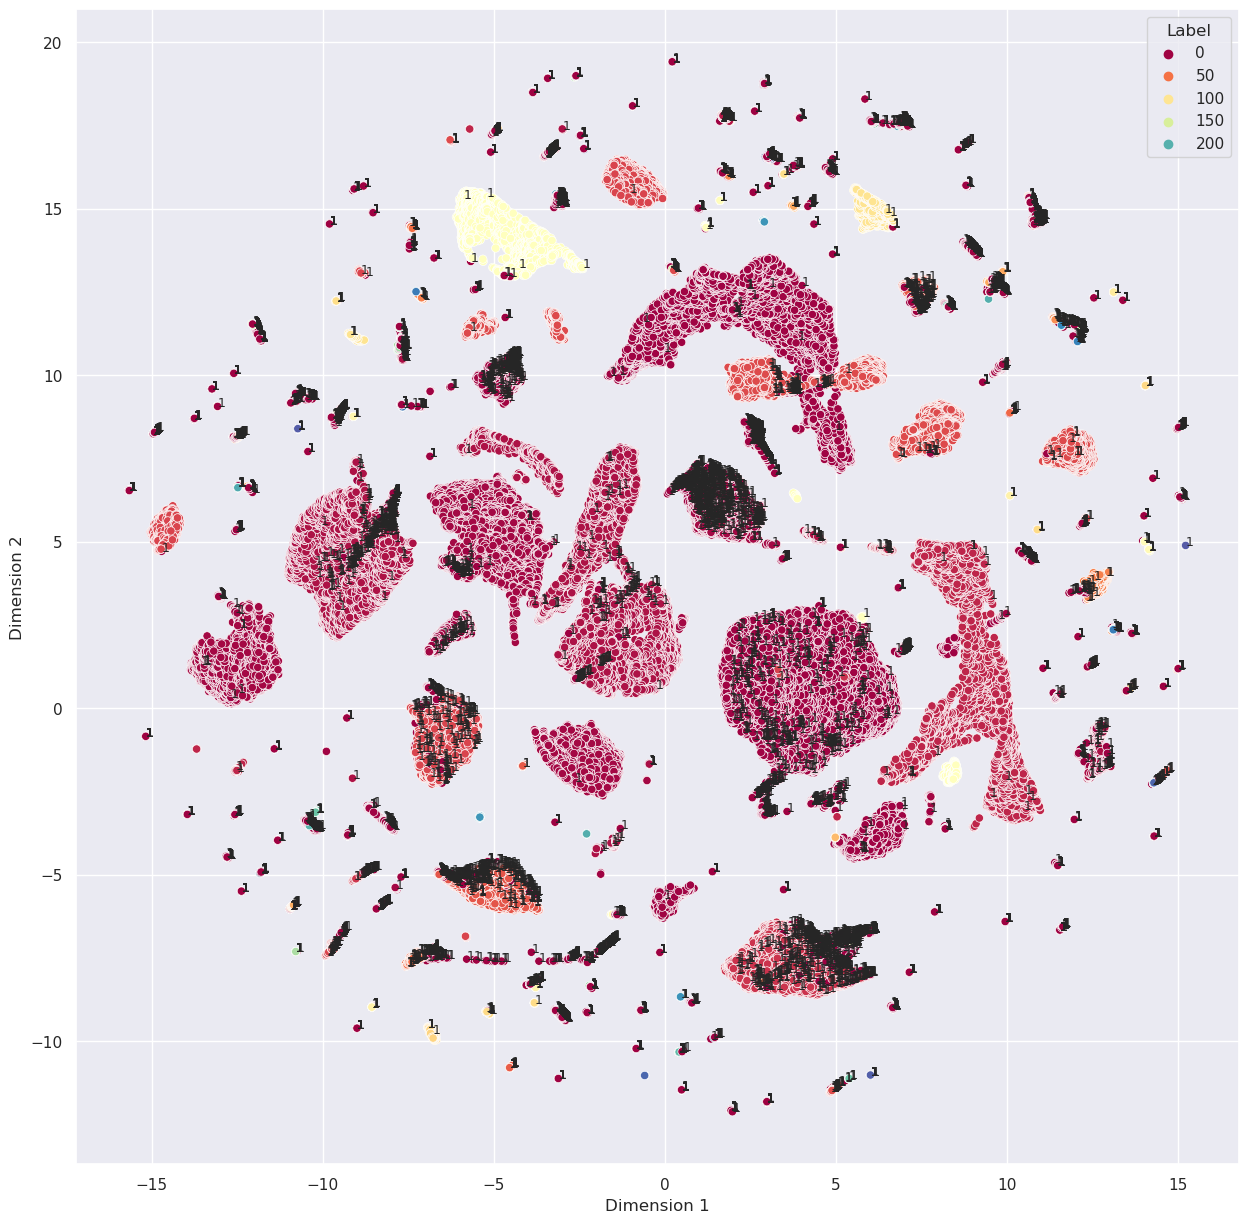

In [42]:
# Trouver les outliers : 

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Label"] == -1) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 9)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()


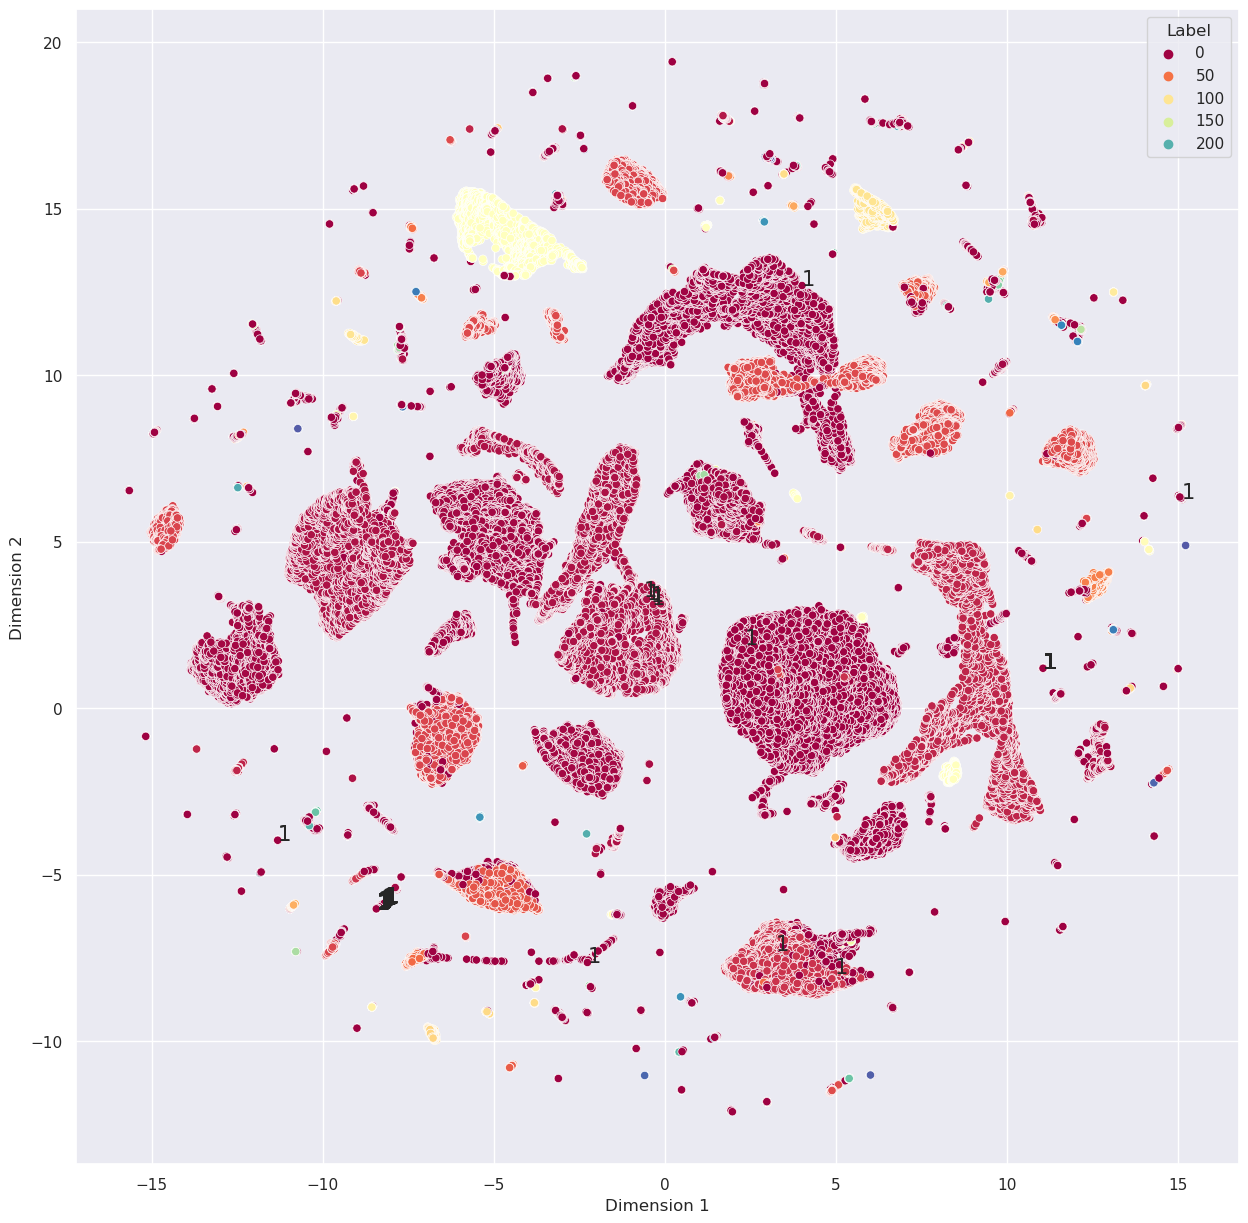

In [43]:
# Trouver les frauds : 
reduced_dfbis = pd.concat([reduced_df, df_cct["Is Fraud?"]], axis = 1)

val = df_cct["Is Fraud?"].unique()[1]

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data = reduced_dfbis, x = "A1", y = "A2", hue = "Label", palette="Spectral")

# boucle sur chaque pays
for k in reduced_dfbis.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (k[1]["Is Fraud?"] == val) :
        ax.annotate("1", (k[1]['A1'], k[1]['A2']), fontsize = 15)
plt.xlabel("Dimension 1") 
plt.ylabel("Dimension 2")
plt.show()

In [44]:
# Rappel : nbr de Fraud dans le dataset : 
len(df_cct1[df_cct1["Is Fraud?"]== df_cct["Is Fraud?"].unique()[1]]) # => 29,757 frauds out of 24,386,900 transactions

29757

In [45]:
# nbr de Fraud sur les 150 000 premières lignes : 
len(df_cct[df_cct["Is Fraud?"]== df_cct["Is Fraud?"].unique()[1]]) # => 147

#Pas bcp...

147